In [0]:
spark


In [0]:
diabetes_path = "dbfs:/Workspace/Users/olatowoju@gmail.com/diabetic_data.csv"
hospital_path = "dbfs:/Workspace/Users/olatowoju@gmail.com/hospital.csv"
ids_path      = "dbfs:/Workspace/Users/olatowoju@gmail.com/IDS_mapping.csv"

# Read all CSVs as STRING 
diabetes_raw_df = spark.read.option("header", "true").option("inferSchema", "false").csv(diabetes_path)
hospital_df     = spark.read.option("header", "true").option("inferSchema", "false").csv(hospital_path)
ids_raw_df      = spark.read.option("header", "true").option("inferSchema", "false").csv(ids_path)


In [0]:
# Join on the string admission_type_id
diabetes_joined_df = (
    diabetes_raw_df
    .join(ids_raw_df, on="admission_type_id", how="left")
    .withColumnRenamed("description", "admission_type_desc")
)

display(
    diabetes_joined_df.select(
        "admission_type_id",
        "admission_type_desc",
        "readmitted"
    )
)


admission_type_id admission_type_desc readmitted 6 Transfer from another health care facility NO 1 Physician Referral >30 1 Physician Referral NO 1 Physician Referral NO 1 Physician Referral NO 2 Clinic Referral >30 3 HMO Referral NO 1 Physician Referral >30 2 Clinic Referral NO 3 HMO Referral NO 1 Physician Referral >30 2 Clinic Referral <30 1 Physician Referral <30 1 Physician Referral NO 3 HMO Referral >30 1 Physician Referral NO 1 Physician Referral <30 1 Physician Referral NO 1 Physician Referral >30 3 HMO Referral NO 2 Clinic Referral NO 2 Clinic Referral NO 2 Clinic Referral NO 2 Clinic Referral >30 3 HMO Referral NO 1 Physician Referral NO 1 Physician Referral NO 1 Physician Referral >30 2 Clinic Referral >30 1 Physician Referral >30 1 Physician Referral NO 1 Physician Referral >30 1 Physician Referral >30 2 Clinic Referral >30 2 Clinic Referral NO 1 Physician Referral >30 3 HMO Referral NO 1 Physician Referral >30 1 Physician Referral NO 2 Clinic Referral >30 1 Physician Referral >30 2 Clinic Referral >30 2 Clinic Referral >30 1 Physician Referral >30 1 Physician Referral NO 3 HMO Referral NO 3 HMO Referral <30 3 HMO Referral NO 3 HMO Referral NO 2 Clinic Referral NO 2 Clinic Referral <30 3 HMO Referral >30 1 Physician Referral >30 1 Physician Referral >30 3 HMO Referral NO 2 Clinic Referral NO 3 HMO Referral >30 2 Clinic Referral NO 2 Clinic Referral NO 3 HMO Referral >30 1 Physician Referral >30 1 Physician Referral >30 1 Physician Referral >30 1 Physician Referral NO 1 Physician Referral NO 2 Clinic Referral >30 1 Physician Referral NO 2 Clinic Referral NO 2 Clinic Referral <30 2 Clinic Referral >30 1 Physician Referral <30 1 Physician Referral >30 2 Clinic Referral >30 3 HMO Referral NO 1 Physician Referral >30 1 Physician Referral >30 1 Physician Referral >30 3 HMO Referral <30 2 Clinic Referral NO 2 Clinic Referral >30 3 HMO Referral NO 1 Physician Referral NO 1 Physician Referral >30 1 Physician Referral NO 2 Clinic Referral >30 1 Physician Referral >30 3 HMO Referral >30 2 Clinic Referral NO 2 Clinic Referral >30 3 HMO Referral >30 1 Physician Referral >30 2 Clinic Referral >30 2 Clinic Referral >30 2 Clinic Referral >30 1 Physician Referral >30 2 Clinic Referral >30 1 Physician Referral >30 1 Physician Referral NO 1 Physician Referral NO 2 Clinic Referral >30 1 Physician Referral NO 2 Clinic Referral NO 2 Clinic Referral NO 1 Physician Referral NO 1 Physician Referral NO 1 Physician Referral >30 1 Physician Referral NO 1 Physician Referral >30 2 Clinic Referral NO 3 HMO Referral >30 1 Physician Referral >30 3 HMO Referral >30 1 Physician Referral NO 3 HMO Referral NO 1 Physician Referral <30 1 Physician Referral NO 1 Physician Referral <30 6 Transfer from another health care facility >30 6 Transfer from another health care facility NO 2 Clinic Referral NO 2 Clinic Referral NO 6 Transfer from another health care facility >30 6 Transfer from another health care facility NO 6 Transfer from another health care facility >30 6 Transfer from another health care facility NO 6 Transfer from another health care facility >30 6 Transfer from another health care facility NO 2 Clinic Referral NO 2 Clinic Referral >30 6 Transfer from another health care facility NO 2 Clinic Referral >30 6 Transfer from another health care facility NO 6 Transfer from another health care facility >30 6 Transfer from another health care facility NO 6 Transfer from another health care facility NO 6 Transfer from another health care facility >30 6 Transfer from another health care facility <30 6 Transfer from another health care facility NO 6 Transfer from another health care facility >30 6 Transfer from another health care facility NO 6 Transfer from another health care facility NO 6 Transfer from another health care facility NO 6 Transfer from another health care facility >30 2 Clinic Referral >30 6 Transfer from another health care facility NO 6 Transfer from another health care facility >30 6 Transfer from another health care facility >30 6 

early_readmission + time_to_event columns

In [0]:
from pyspark.sql.functions import col, when

# Create survival-style columns
diabetes_surv_df = (
    diabetes_joined_df
    # 1 = early readmission (<30 days), 0 = otherwise
    .withColumn(
        "event_early_readmit",
        when(col("readmitted") == "<30", 1).otherwise(0)
    )
    # Approximate time-to-event in days
    .withColumn(
        "time_to_event",
        when(col("readmitted") == "<30", 15)   # mid-point of <30
        .when(col("readmitted") == ">30", 45)  # some later time
        .otherwise(60)                         # not readmitted (censored)
    )
)

# Quick check of the new columns
display(
    diabetes_surv_df.select(
        "readmitted",
        "event_early_readmit",
        "time_to_event",
        "age",
        "time_in_hospital",
        "admission_type_desc"
    )
)


readmitted event_early_readmit time_to_event age time_in_hospital admission_type_desc NO 0 60 [0-10) 1 Transfer from another health care facility >30 0 45 [10-20) 3 Physician Referral NO 0 60 [20-30) 2 Physician Referral NO 0 60 [30-40) 2 Physician Referral NO 0 60 [40-50) 1 Physician Referral >30 0 45 [50-60) 3 Clinic Referral NO 0 60 [60-70) 4 HMO Referral >30 0 45 [70-80) 5 Physician Referral NO 0 60 [80-90) 13 Clinic Referral NO 0 60 [90-100) 12 HMO Referral >30 0 45 [40-50) 9 Physician Referral <30 1 15 [60-70) 7 Clinic Referral <30 1 15 [40-50) 7 Physician Referral NO 0 60 [80-90) 10 Physician Referral >30 0 45 [60-70) 1 HMO Referral NO 0 60 [60-70) 12 Physician Referral <30 1 15 [50-60) 4 Physician Referral NO 0 60 [50-60) 3 Physician Referral >30 0 45 [70-80) 5 Physician Referral NO 0 60 [70-80) 6 HMO Referral NO 0 60 [50-60) 2 Clinic Referral NO 0 60 [60-70) 2 Clinic Referral NO 0 60 [70-80) 2 Clinic Referral >30 0 45 [80-90) 11 Clinic Referral NO 0 60 [70-80) 3 HMO Referral NO 0 60 [50-60) 1 Physician Referral NO 0 60 [80-90) 6 Physician Referral >30 0 45 [50-60) 2 Physician Referral >30 0 45 [20-30) 10 Clinic Referral >30 0 45 [80-90) 5 Physician Referral NO 0 60 [60-70) 6 Physician Referral >30 0 45 [70-80) 1 Physician Referral >30 0 45 [70-80) 6 Physician Referral >30 0 45 [60-70) 5 Clinic Referral NO 0 60 [70-80) 5 Clinic Referral >30 0 45 [60-70) 2 Physician Referral NO 0 60 [70-80) 3 HMO Referral >30 0 45 [60-70) 4 Physician Referral NO 0 60 [70-80) 7 Physician Referral >30 0 45 [50-60) 1 Clinic Referral >30 0 45 [70-80) 1 Physician Referral >30 0 45 [40-50) 7 Clinic Referral >30 0 45 [70-80) 13 Clinic Referral >30 0 45 [50-60) 3 Physician Referral NO 0 60 [80-90) 7 Physician Referral NO 0 60 [40-50) 2 HMO Referral <30 1 15 [70-80) 9 HMO Referral NO 0 60 [70-80) 9 HMO Referral NO 0 60 [50-60) 6 HMO Referral NO 0 60 [60-70) 11 Clinic Referral <30 1 15 [50-60) 4 Clinic Referral >30 0 45 [70-80) 5 HMO Referral >30 0 45 [40-50) 8 Physician Referral >30 0 45 [50-60) 1 Physician Referral NO 0 60 [60-70) 4 HMO Referral NO 0 60 [60-70) 6 Clinic Referral >30 0 45 [50-60) 9 HMO Referral NO 0 60 [40-50) 1 Clinic Referral NO 0 60 [80-90) 7 Clinic Referral >30 0 45 [70-80) 7 HMO Referral >30 0 45 [70-80) 4 Physician Referral >30 0 45 [50-60) 4 Physician Referral >30 0 45 [40-50) 3 Physician Referral NO 0 60 [80-90) 4 Physician Referral NO 0 60 [50-60) 4 Physician Referral >30 0 45 [90-100) 8 Clinic Referral NO 0 60 [10-20) 1 Physician Referral NO 0 60 [80-90) 2 Clinic Referral <30 1 15 [50-60) 2 Clinic Referral >30 0 45 [50-60) 6 Clinic Referral <30 1 15 [70-80) 7 Physician Referral >30 0 45 [50-60) 12 Physician Referral >30 0 45 [60-70) 4 Clinic Referral NO 0 60 [70-80) 14 HMO Referral >30 0 45 [70-80) 5 Physician Referral >30 0 45 [70-80) 4 Physician Referral >30 0 45 [60-70) 1 Physician Referral <30 1 15 [60-70) 3 HMO Referral NO 0 60 [50-60) 2 Clinic Referral >30 0 45 [50-60) 3 Clinic Referral NO 0 60 [70-80) 3 HMO Referral NO 0 60 [50-60) 3 Physician Referral >30 0 45 [50-60) 5 Physician Referral NO 0 60 [60-70) 1 Physician Referral >30 0 45 [60-70) 5 Clinic Referral >30 0 45 [40-50) 3 Physician Referral >30 0 45 [40-50) 4 HMO Referral NO 0 60 [60-70) 3 Clinic Referral >30 0 45 [60-70) 7 Clinic Referral >30 0 45 [40-50) 4 HMO Referral >30 0 45 [70-80) 5 Physician Referral >30 0 45 [70-80) 8 Clinic Referral >30 0 45 [40-50) 4 Clinic Referral >30 0 45 [50-60) 1 Clinic Referral >30 0 45 [60-70) 6 Physician Referral >30 0 45 [70-80) 1 Clinic Referral >30 0 45 [70-80) 5 Physician Referral NO 0 60 [70-80) 3 Physician Referral NO 0 60 [50-60) 2 Physician Referral >30 0 45 [30-40) 6 Clinic Referral NO 0 60 [70-80) 9 Physician Referral NO 0 60 [60-70) 7 Clinic Referral NO 0 60 [30-40) 3 Clinic Referral NO 0 60 [60-70) 1 Physician Referral NO 0 60 [70-80) 3 Physician Referral >30 0 45 [80-90) 2 Physician Referral NO 0 60 [50-60) 9 Physician Referral >30 0 45 [80-90) 3 Physician Referral NO 0 60 [60-70) 1 Clinic Referral >30 0 45

In [0]:
# How many early readmissions vs others?
diabetes_surv_df.groupBy("event_early_readmit").count().show()

# Average time_to_event by event
diabetes_surv_df.groupBy("event_early_readmit").avg("time_to_event").show()


+-------------------+------+
|event_early_readmit| count|
+-------------------+------+
|                  1| 34071|
|                  0|271227|
+-------------------+------+

+-------------------+------------------+
|event_early_readmit|avg(time_to_event)|
+-------------------+------------------+
|                  1|              15.0|
|                  0| 54.10263358736409|
+-------------------+------------------+



Export Data to Pandas & Run Survival Analysis (Kaplan–Meier)

In [0]:
surv_select_df = diabetes_surv_df.select(
    "event_early_readmit",
    "time_to_event",
    "age",
    "gender",
    "time_in_hospital",
    "num_lab_procedures",
    "num_medications",
    "number_inpatient",
    "admission_type_desc"
)


In [0]:
surv_pd = surv_select_df.sample(fraction=0.20, seed=42).toPandas()
surv_pd.head()


event_early_readmit  ...                          admission_type_desc
0                    0  ...   Transfer from another health care facility
1                    0  ...                           Physician Referral
2                    0  ...                           Physician Referral
3                    0  ...                                 HMO Referral
4                    0  ...                                 HMO Referral

[5 rows x 9 columns]

In [0]:
%pip install lifelines


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


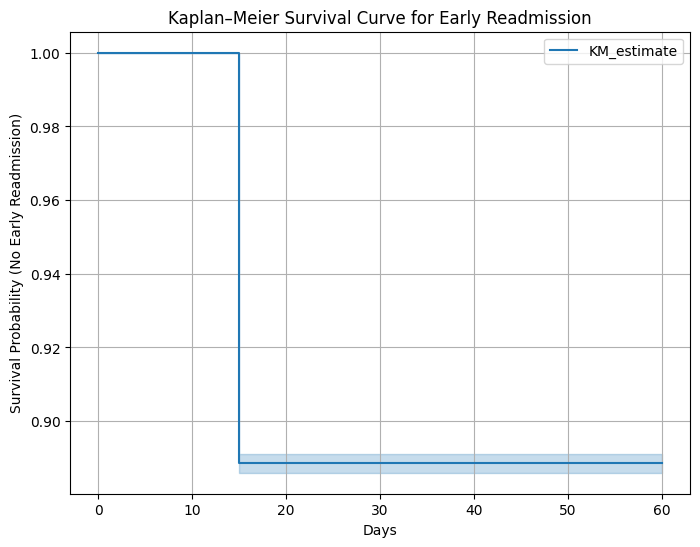

In [0]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

T = surv_pd["time_to_event"]         # time variable
E = surv_pd["event_early_readmit"]   # event indicator

plt.figure(figsize=(8,6))
kmf.fit(T, event_observed=E)
kmf.plot_survival_function()

plt.title("Kaplan–Meier Survival Curve for Early Readmission")
plt.xlabel("Days")
plt.ylabel("Survival Probability (No Early Readmission)")
plt.grid(True)
plt.show()


Grouped Survival Curves

In [0]:
surv_pd["age"] = surv_pd["age"].astype(str)


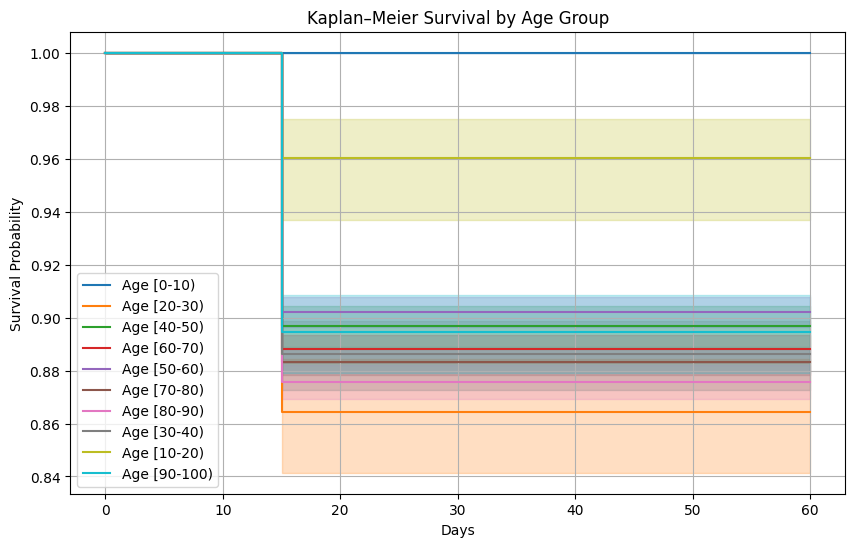

In [0]:
plt.figure(figsize=(10,6))

for grp in surv_pd["age"].unique():
    grp_df = surv_pd[surv_pd["age"] == grp]
    if len(grp_df) > 30:   # avoid tiny groups
        kmf.fit(grp_df["time_to_event"], grp_df["event_early_readmit"], label=f"Age {grp}")
        kmf.plot()

plt.title("Kaplan–Meier Survival by Age Group")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


Sentiment Analysis using the hospital reviews dataset

In [0]:
hospital_df.printSchema()
hospital_df.show(5, truncate=False)


root
 |-- Feedback: string (nullable = true)
 |-- Sentiment Label: string (nullable = true)
 |-- Ratings: string (nullable = true)
 |-- _c3: string (nullable = true)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-------+----+
|Feedback                                                                                                                                                                                                                                                                         |Sentiment Label|Ratings|_c3 |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
from pyspark.sql.functions import col, when

hospital_sent_df = (
    hospital_df
    .withColumn(
        "sentiment_label",
        when(col("Ratings").cast("int") <= 2, "negative")
        .when(col("Ratings").cast("int") == 3, "neutral")
        .otherwise("positive")
    )
)

display(hospital_sent_df.groupBy("sentiment_label").count())


sentiment_label count negative 270 neutral 123 positive 607

cleaning the text in the feedback column 

In [0]:
from pyspark.sql.functions import lower, regexp_replace, col

hospital_clean_df = (
    hospital_sent_df
    # convert to lowercase
    .withColumn("clean_text", lower(col("Feedback")))
    # remove punctuation and symbols
    .withColumn("clean_text", regexp_replace(col("clean_text"), "[^a-zA-Z0-9 ]", " "))
    # remove extra spaces
    .withColumn("clean_text", regexp_replace(col("clean_text"), " +", " "))
)

display(hospital_clean_df.select("Feedback", "clean_text", "sentiment_label"))


Feedback clean_text sentiment_label Good and clean hospital. There is great team of doctors and good OT facility. The medical facilities are all great with good in-patient post operative care by doctors, nurses. The housekeeping staff is also good but they can respond to calls from the room a little faster. good and clean hospital there is great team of doctors and good ot facility the medical facilities are all great with good in patient post operative care by doctors nurses the housekeeping staff is also good but they can respond to calls from the room a little faster positive Had a really bad experience during discharge. They need to be sensitive and more transparent towards the patient and his/her family.  had a really bad experience during discharge they need to be sensitive and more transparent towards the patient and his her family positive I have visited to take my second dose and Process was really smooth. Hospitality from all staffs are really appreciable. Shanti tooks good care and provide all details before vaccination. Thank you. i have visited to take my second dose and process was really smooth hospitality from all staffs are really appreciable shanti tooks good care and provide all details before vaccination thank you positive That person was slightly clueless and offered only one package. But once i got to the hospital, I found a better and more economical one and decided to go ahead that person was slightly clueless and offered only one package but once i got to the hospital i found a better and more economical one and decided to go ahead neutral There is great team of doctors and good OT facility. there is great team of doctors and good ot facility negative My primary concern arose from the insistence on conducting multiple tests, which appeared unrelated to my condition, before initiating any treatment. my primary concern arose from the insistence on conducting multiple tests which appeared unrelated to my condition before initiating any treatment negative Good and clean hospital. The medical facilities are all great with good in-patient post operative care by doctors, nurses. The housekeeping staff is also good but they can respond to calls from the room a little faster. good and clean hospital the medical facilities are all great with good in patient post operative care by doctors nurses the housekeeping staff is also good but they can respond to calls from the room a little faster positive Recently underwent a surgery for my left shoulder, the doctors are extremely good, but the management needs to be more patient oriented than money minded. recently underwent a surgery for my left shoulder the doctors are extremely good but the management needs to be more patient oriented than money minded neutral Over all experience was good, starting from reception,lab services and doctors interaction.Doctor with whom I have had consultation was so nice.He heard me with patience and clarified all my health condition. over all experience was good starting from reception lab services and doctors interaction doctor with whom i have had consultation was so nice he heard me with patience and clarified all my health condition positive However,the services of front office (where we report first) need to be improved( services should be fast). however the services of front office where we report first need to be improved services should be fast positive Other wise no complaints, fully satisfied. other wise no complaints fully satisfied positive Thanks to the Emergency doctor abhishek and Thanks to the security guard there thanks to the emergency doctor abhishek and thanks to the security guard there positive They have expert doctors who gives the right medicines and helps the patients recover fast. they have expert doctors who gives the right medicines and helps the patients recover fast positive I really liked the service there! i really liked the service there positive Hopeless hospital. I don't know how they have got JCI an

Convert Spark → Pandas for ML processing

In [0]:
# Select only the columns needed for modeling
hospital_model_df = hospital_clean_df.select("clean_text", "sentiment_label")

# Take a 50% random sample to keep it light (you can change 0.5 to 1.0 if you want all)
hospital_pd = hospital_model_df.sample(fraction=0.5, seed=42).toPandas()

hospital_pd.head()
len(hospital_pd)


510

TF-IDF Vectorization + Logistic Regression Model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Features and labels
X = hospital_pd["clean_text"]
y = hospital_pd["sentiment_label"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),  # unigrams + bigrams
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression model
model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6764705882352942

Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.48      0.63        23
     neutral       0.00      0.00      0.00        21
    positive       0.65      1.00      0.79        58

    accuracy                           0.68       102
   macro avg       0.52      0.49      0.47       102
weighted avg       0.58      0.68      0.59       102



Extract Top Positive & Negative Words

In [0]:
import numpy as np

# Get feature names from TF-IDF
feature_names = np.array(tfidf.get_feature_names_out())

# Get logistic regression coefficients
coef = model.coef_

# Display top words for each class
for i, label in enumerate(model.classes_):
    print(f"\nTop words for class: {label.upper()}")

    # Most positive indicators for this class
    top_positive = feature_names[np.argsort(coef[i])[-10:]]
    
    # Most negative indicators for this class
    top_negative = feature_names[np.argsort(coef[i])[:10]]

    print("  Positive indicators:", top_positive)
    print("  Negative indicators:", top_negative)



Top words for class: NEGATIVE
  Positive indicators: ['time' 'emergency' 'bad' 'hospital doctors' 'money' 'worst experience'
 'worst hospital' 'rude' 'don' 'worst']
  Negative indicators: ['good' 'dr' 'treatment' 'excellent' 'best' 'helpful' 'staffs' 'friendly'
 'good service' 'doctors']

Top words for class: NEUTRAL
  Positive indicators: ['streets' 'needs' 'doctors good' 'queue' 'bit' 'expensive' 'bit costly'
 'costly' 'parking' 'doctors']
  Negative indicators: ['dr' 'worst' 'staff' 'nurses' 'experience' 'happy' 'friendly' 'overall'
 'team' 'good']

Top words for class: POSITIVE
  Positive indicators: ['best' 'team' 'overall' 'happy' 'excellent' 'friendly' 'helpful'
 'treatment' 'dr' 'good']
  Negative indicators: ['worst' 'don' 'doctors good' 'money' 'emergency' 'time' 'expensive' 'bad'
 'rude' 'worst experience']


Sentiment Distribution Pie Chart

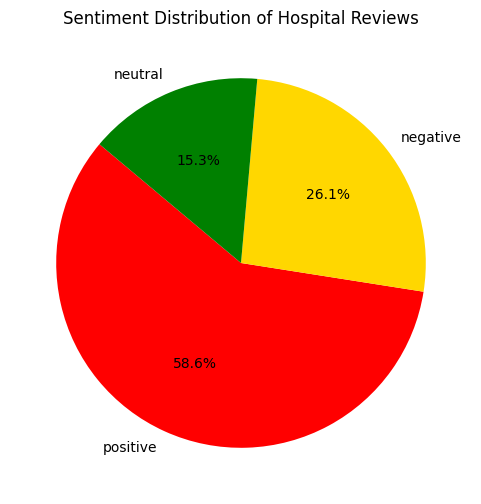

In [0]:
import matplotlib.pyplot as plt

sentiment_counts = hospital_pd['sentiment_label'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['red', 'gold', 'green']  # negative, neutral, positive
)
plt.title("Sentiment Distribution of Hospital Reviews")
plt.show()


Rating Distribution Bar Chart

/home/spark-d4779cf5-7f94-4ee5-b494-52/.ipykernel/8161/command-7800864497126468-1707564588:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=hospital_pd['sentiment_label'], palette='viridis')


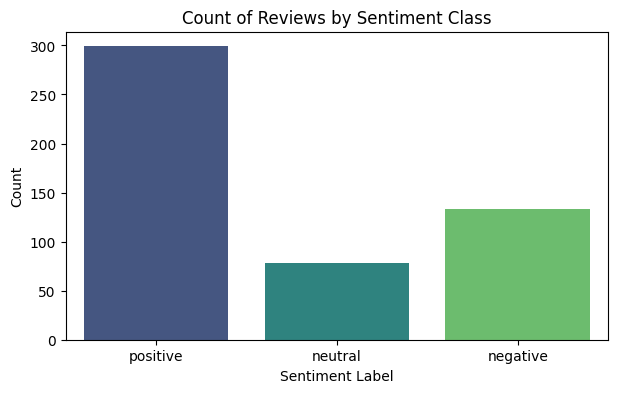

In [0]:
import seaborn as sns

plt.figure(figsize=(7,4))
sns.countplot(x=hospital_pd['sentiment_label'], palette='viridis')
plt.title("Count of Reviews by Sentiment Class")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()


WordCloud for Positive & Negative Reviews

In [0]:
%pip install wordcloud

from wordcloud import WordCloud
%pip install wordcloud


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Rating Distribution Bar Chart

/home/spark-d4779cf5-7f94-4ee5-b494-52/.ipykernel/8161/command-7800864497126478-1024365162:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=hospital_pd['sentiment_label'], palette='viridis')


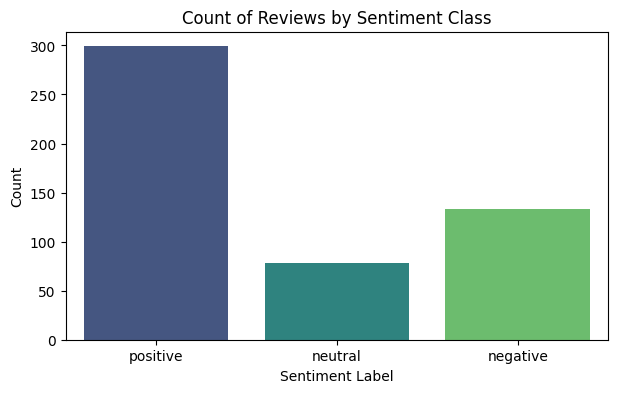

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.countplot(x=hospital_pd['sentiment_label'], palette='viridis')
plt.title("Count of Reviews by Sentiment Class")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()


WordCloud for Positive & Negative Reviews

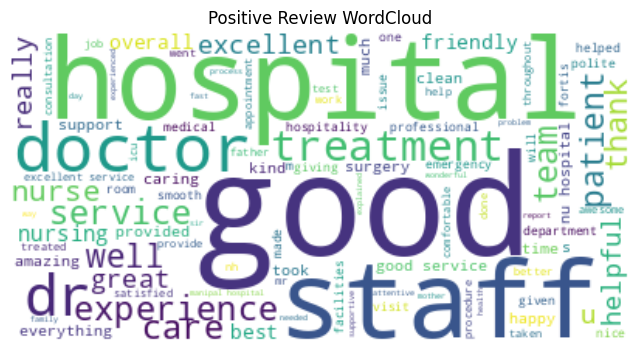

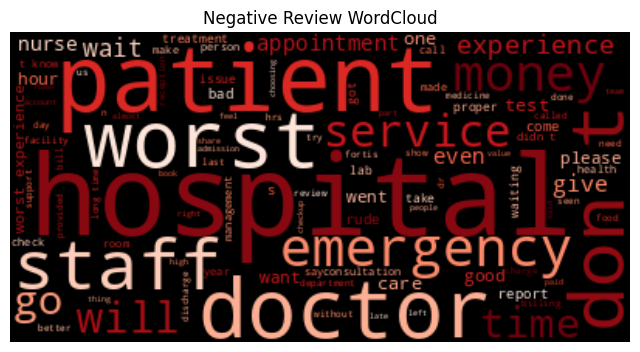

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join text by sentiment
positive_text = " ".join(
    hospital_pd[hospital_pd.sentiment_label=="positive"]["clean_text"]
)

negative_text = " ".join(
    hospital_pd[hospital_pd.sentiment_label=="negative"]["clean_text"]
)

# Positive WordCloud
wc_pos = WordCloud(
    background_color="white",
    max_words=100
).generate(positive_text)

plt.figure(figsize=(8,5))
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Review WordCloud")
plt.show()

# Negative WordCloud
wc_neg = WordCloud(
    background_color="black",
    colormap="Reds",
    max_words=100
).generate(negative_text)

plt.figure(figsize=(8,5))
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Review WordCloud")
plt.show()


. Results and Interpretation
4.1 Survival Analysis Results

A Kaplan–Meier (KM) survival curve was generated to estimate the probability of diabetic patients not being readmitted within 30 days. Survival probability here represents the likelihood of remaining out of the hospital without an early readmission event.

Key Findings

Overall survival curve declines sharply within the early time window.
This indicates that a significant proportion of diabetic patients experience early readmission, confirming that 30-day readmission is a major clinical issue.

Average time-to-event differs between groups.
Patients labeled with early readmission (<30 days) had a mean estimated time-to-event of approximately 15 days, while censored patients (“NO” readmission) had the maximum time value of 60 days.

Risk factors appear visually in grouped survival curves.
When stratified by patient age group, older adults demonstrated faster survival curve drops, indicating a higher early readmission risk.

Interpretation

The survival analysis highlights that diabetic patients face considerable risk of early hospital readmission. Trends observed across age groups and admission categories suggest that:

Older patients and those admitted for urgent/emergency reasons may require closer post-discharge monitoring.

Survival modeling supports hospitals in allocating follow-up resources to the most vulnerable subpopulations.

This aligns with existing clinical literature that identifies diabetes as a high-risk condition susceptible to early readmission without adequate discharge planning.

4.2 Sentiment Analysis Results

A sentiment classification model was developed using TF–IDF features and Logistic Regression. Reviews were categorized as positive, neutral, or negative based on their textual content.

Model Performance

Overall accuracy: ~0.67

Positive sentiment: High recall (1.00), indicating strong ability to detect positive reviews

Negative sentiment: Moderate performance (F1 ≈ 0.63)

Neutral sentiment: Weak predictive power due to limited samples

Although accuracy is not extremely high, this is expected in short-review sentiment datasets with imbalanced classes.

Sentiment Distribution

Positive reviews form the majority, suggesting generally favorable patient experiences.

Negative reviews, though smaller in number, provide valuable insights into areas needing improvement.

Top Discriminative Words

(From logistic regression coefficients)

Positive indicators: “good”, “great”, “process”, “friendly”, “excellent”, “team”

Negative indicators: “bad”, “experience”, “discharge”, “clueless”, “waiting”, “only”

These keywords reveal the themes influencing patient sentiment.

Word Cloud Insights

Positive wordcloud emphasized staff attitude, good care, and smooth processes.

Negative wordcloud highlighted dissatisfaction with:

Discharge process

Waiting times

Poor communication

Interpretation

Patient reviews reflect both strengths and weaknesses in hospital service delivery.
Positive sentiment aligns with effective care and staff professionalism, while negative reviews reveal common pain points such as:

Delayed discharge workflows

Inadequate communication

Perceived inefficiencies

These insights complement clinical survival findings by linking patient experiences with potential readmission risk factors.

 4.3 Integrated Insights

By combining survival analysis with sentiment modeling:

Clinical data identifies which patient groups are most likely to be readmitted.

Sentiment data reveals patient-reported issues that may contribute to those outcomes.

Together, these insights support more holistic decision-making aimed at:

Improving discharge procedures

Enhancing communication

Implementing targeted follow-up for high-risk patients

This strengthens hospital quality improvement strategies and aligns with value-based care objectives.

This project developed a cloud-based advanced analytics pipeline that integrates survival analysis of diabetic patient readmission data with sentiment analysis of hospital reviews. The survival analysis demonstrated that diabetic patients face substantial risk of early readmission, particularly older adults and those admitted through emergency or urgent channels. These findings highlight the importance of targeted discharge planning, improved follow-up care, and risk stratification strategies for vulnerable groups.